# Elements of Data Science: A First Course 

# COMS W4995 008 2017 3


## Week 7: Feature Selection, Model Evaluation and Selection

## Reading: 

- Midterm Topics
- Midterm practice questions

## Today

- Model Evalation and Selection
- Regression
    - MSE
    - Residuals
    - R^2
    - AIC

- Bias, Variance tradeoff
- Overfitting and Underfitting
    - the Train/Test split
    - Validation Curve
- Cross Validation
- Grid Search

- Classification
    - Accuracy and Error
    - Confusion Matrix
    - Precision vs. Recall

- Feature Selection
    - Stepwise
    - Regularization
    - Feature Importance

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(123)
%matplotlib inline

## Model Evaluation and Selection : Regression

$y_i$: the ground truth label for observation $i$

$\hat{y}_i$: the prediction $f(x_i)$

### Root Mean Squared Error

- in (0, inf)
- describes accuracy

$$
RMSE = \sqrt{\frac{1}{n}\sum \left(\hat{y}_i - y_i\right)^2}
$$

In [2]:
df = pd.read_csv('../data/LungDisease.csv', header=0)

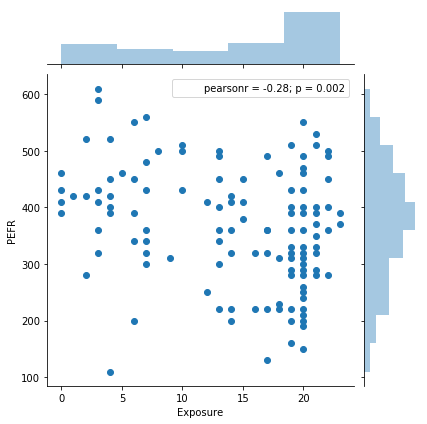

In [3]:
_ = sns.jointplot(x='Exposure',y='PEFR',data=df)

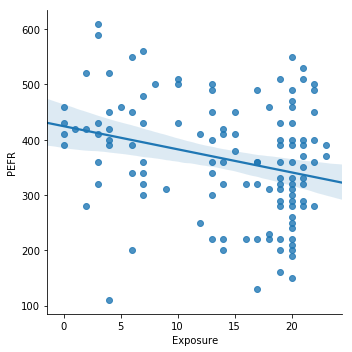

In [4]:
_ = sns.lmplot(x='Exposure',y='PEFR',data=df)

In [5]:
X = df.Exposure.values.reshape(-1,1)
y = df.PEFR

In [6]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X, y)
print('b_0: {}'.format(lr.intercept_))
print('b_1: {}'.format(lr.coef_[0]))

b_0: 424.582806573957
b_1: -4.184576485461442


In [7]:
y_pred = lr.predict(X)

In [8]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y,y_pred))

print('sqrt mean squared error: {}'.format(rmse))

sqrt mean squared error: 100.60327397934422


### $R^2$

- best is 1
- describes amount of variance explained by the model
- used more in exploration

$$
R^2 = 1 - \frac{\sum \left(\hat{y}_i - y_i\right)^2}{\sum \left(\bar{y} - y_i\right)^2}
$$

In [9]:
from sklearn.metrics import r2_score

r2 = r2_score(y,y_pred)

print('r^2: {}'.format(r2))

r^2: 0.0767410228628338


#### using statsmodels

In [10]:
import statsmodels.formula.api as smf

model = smf.ols(formula='PEFR ~ Exposure', data=df)

result = model.fit()

In [11]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PEFR   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     9.974
Date:                Thu, 19 Oct 2017   Prob (F-statistic):            0.00201
Time:                        16:14:08   Log-Likelihood:                -735.68
No. Observations:                 122   AIC:                             1475.
Df Residuals:                     120   BIC:                             1481.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    424.5828     20.796     20.417      0.000     383.408     465.757
Exposure      -4.1846      1.325     -3.158      0.002      -6.808      -1.561
==============================================================================
Omnibus:                        0.767   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.681   Jarque-Bera (JB):                0.891
Skew:                          -0.162   Prob(JB):                        0.641
Kurtosis:                       2.734   Cond. No.                         35.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Evaluate Residuals

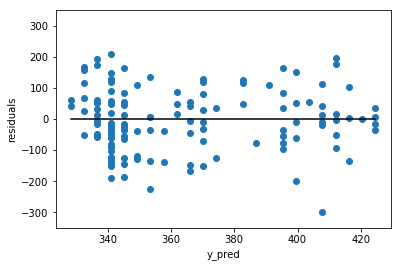

In [12]:
y_pred = result.predict(df.Exposure)
_ = plt.scatter(y_pred,result.resid)
_ = plt.plot([np.min(y_pred),np.max(y_pred)],[0,0], color='k')
_ = plt.ylabel('residuals')
_ = plt.xlabel('y_pred')
_ = plt.ylim([-350,350])

### AIC (Akaike's Information Criterion)

- adding features always decreases RMSE and increases R^2
- AIC penalizes adding features to a model

#### Residual Sum of Squares
$$
RSS = \sum (\hat{y}_i - y_i)
$$

$$
AIC = 2p + n \log\left(\frac{RSS}{n}\right)
$$

## Overfitting, Underfitting and Train/Test Split

In [13]:
lr = LinearRegression()
lr.fit(X,y)
lr.score(X,y) # r2 score

0.076741022862833796

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(PolynomialFeatures(degree=10),
                     LinearRegression(fit_intercept=False))

pipe.fit(X,y)
pipe.score(X,y) # r2 score

0.16083731105474219

### Bias vs. Variance

<img src="images/05.03-bias-variance.png">

### How to tell if you're Over/Underfitting: Test/Hold-out-set

**Generalization** (aka out-of-sample error): a measure of how accurately an algorithm is able to predict outcome values for previously unseen data.

<img src="images/05.03-bias-variance-2.png">

**Train**: used to train model

**Test (aka out-of-sample)**: used to evaluate model

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.5,
                                                    random_state=0)

In [16]:
lr.fit(X_train,y_train)
lr.score(X_test,y_test) # r2 score

0.13577181411248684

In [17]:
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test) # r2 score

0.057934480006397449

Avoid overfitting and underfitting by:

- underfitting: More complicated/more flexible model
- overfitting: Less complicated/more flexible model
- both: Gather more training samples
- both: Gather new features

### Really shouldn't look at the test set till the end
### But then how do we find a good model?

### Cross-Validation

<img src="https://cdn-images-1.medium.com/max/1600/1*J2B_bcbd1-s1kpWOu_FZrg.png">

In [18]:
from sklearn.model_selection import cross_val_score

train_scores = cross_val_score(lr, X_train, y_train, cv=5) # r^2
print(train_scores)
print(np.median(train_scores))

[-0.6915684  -0.01012053  0.03956973  0.01791263 -0.11810844]
-0.0101205281074


In [19]:
train_scores = cross_val_score(pipe, X_train, y_train, cv=5) # r^2
print(train_scores)
print(np.median(train_scores))

[-23.66543421  -0.4252908   -1.62261467  -0.22415905  -0.29967702]
-0.425290804654


### Choosing (hyper-parameters): Validation Curve

In [20]:
from sklearn.preprocessing import RobustScaler

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(RobustScaler(),
                         PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [21]:
from sklearn.model_selection import validation_curve

degree = np.arange(0,10)
train_score, validation_score = validation_curve(PolynomialRegression(),
                                                 X_train, y_train,
                                                 'polynomialfeatures__degree',
                                                 degree, cv=3)

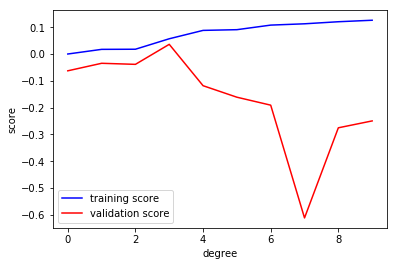

In [22]:
_ = plt.plot(degree, np.median(train_score,1), color='b',label='training score')
_ = plt.plot(degree, np.median(validation_score,1), color='r', label='validation score')
_ = plt.xlabel('degree'), plt.ylabel('score')
_ = plt.legend(loc='best')

### Searching for the best model: GridSearch


In [23]:
from sklearn.model_selection import GridSearchCV

params = {'polynomialfeatures__degree':[1,3,7],
          'linearregression__fit_intercept': [False, True]}

pr = PolynomialRegression(normalize=True)

gscv = GridSearchCV(pr,params,cv=3)

gscv.fit(X_train,y_train)

print(gscv.best_params_)

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 3}


In [24]:
print(gscv.best_estimator_.score(X_test,y_test))

0.118289856616


### How to make regression with many features simpler ?

- reduce number of independent variables (feature selection)


- reduce the coefficients on variables

### Regularization: reduce the effect of features

- Ridge Regression ($\ell^2$): drives coefficents small

- LASSO ($\ell^1$): drives coefficients to zero

- ElasticNet ($\ell^2 + \lambda \ell^1$)

In [25]:
df = pd.read_csv('../data/house_sales.csv',sep='\t')
cols_to_keep = ['AdjSalePrice','SqFtTotLiving','Bathrooms','Bedrooms','BldgGrade','SqFtFinBasement','YrBuilt']
df = df[cols_to_keep]

In [26]:
from scipy.stats.mstats import zscore
df = df.apply(zscore)

In [27]:
idx = np.random.permutation(len(df))[:1000]
X = df.iloc[idx,1:]
y = df.iloc[idx,0]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=0)

In [29]:
lr.fit(X_train,y_train)
y_pred = lr.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
r2 = r2_score(y_train,y_pred)
print('RMSE: {}'.format(rmse))
print(' R^2: {}'.format(r2))

RMSE: 0.650558793098329
 R^2: 0.5570312358612804


In [30]:
from sklearn.linear_model import ElasticNetCV

en = ElasticNetCV(l1_ratio=[.1, .5, .9, .95, .99, 1])

en.fit(X_train, y_train)
y_pred = en.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
r2 = r2_score(y_train,y_pred)

print('l1_ratio: {}'.format(en.l1_ratio_))
print('    RMSE: {}'.format(rmse))
print('     r^2: {}'.format(r2))

l1_ratio: 1.0
    RMSE: 0.6505635525645
     r^2: 0.5570247543485188


## Review

- Regression: RMSE
- Regression: $R^2$
- Bias/Variance Tradeoff
- Overfitting/Underfitting
- Train/Test split
- Cross-Validation
- Grid-Search
- Regularization

## Model Evaluation and Selection : Classification

### Accuracy

$$
\text{accuracy} = \frac{\text{number correct}}{\text{total}}
$$

$$
accuracy\left(\hat{y},y\right) = \frac{1}{n} \sum_{i=1:n} \delta \left[\hat{y}_i = y_i\right]
$$

$$
\delta(a) = \begin{cases}
1 &\text{if } a \text{ is true}, \\ 
0 &\text{o.w.}
\end{cases}
$$

In [31]:
df = pd.read_csv('../data/loan_data.csv', header=0, index_col=0)

df = pd.concat([pd.get_dummies(df.outcome,drop_first=True),df.loan_amnt,pd.get_dummies(df.purpose_)],axis=1)

df.head()

,paid off,loan_amnt,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business
1,0,2500,0,0,0,1,0,0,0
2,0,5600,0,0,0,0,0,0,1
3,0,5375,0,0,0,0,0,1,0
4,0,9000,0,1,0,0,0,0,0
5,0,10000,0,0,0,0,0,1,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:],
                                                    df.iloc[:,0], 
                                                    test_size=.25,
                                                    stratify=df.iloc[:,0],
                                                    random_state=0)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rfc = RandomForestClassifier(n_estimators=5)

rfc.fit(X_train,y_train)

rfc.score(X_train,y_train) # accuracy

0.6067164618008587

In [35]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='most_frequent')

rfc_train_scores = cross_val_score(rfc, X_train, y_train, cv=5) # accuracy

dc_train_scores = cross_val_score(dc, X_train, y_train, cv=5) # accuracy


print('randomforest accuracy : {}'.format(np.median(rfc_train_scores)))
print('dummy accuracy        : {}'.format(np.median(dc_train_scores)))

#print('randomforest accuracy on test: {}'.format(rfc.score(X_test,y_test)))
#print('dummy accuracy on test       : {}'.format(dc.score(X_test,y_test)))

randomforest accuracy : 0.5489705882352941
dummy accuracy        : 0.5


### Error

$$
\text{error} = \frac{\text{number incorrect}}{\text{total}}
$$

$$
error\left(\hat{y},y\right) = \frac{1}{n} \sum_{i=1:n} \delta \left[\hat{y}_i \neq y_i\right]
$$

<img src="http://2378nh2nfow32gm3mb25krmuyy.wpengine.netdna-cdn.com/wp-content/uploads/2014/05/Type-I-and-II-errors1-625x468.jpg">

### Confusion Matrix

<img src="https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png">

### Precision

"Out of the ones I called positive, how many were truly positive?"

$$
precision = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

### Recall

"Out of the truly positive, how many did I call positive?"

$$
recall = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

In [36]:
from sklearn.metrics import precision_recall_curve

In [37]:
y_pred = rfc.predict_proba(X_train)

In [38]:
y_pred[:3]

array([[ 0.48488371,  0.51511629],
       [ 0.54682188,  0.45317812],
       [ 0.63333333,  0.36666667]])

In [39]:
# y_pred[:,1] = P(y = 1)

precision, recall, _ = precision_recall_curve(y_train, y_pred[:,1])

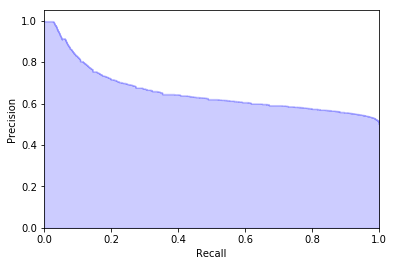

In [40]:
plt.step(recall, precision,
         color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision,
                 color='b', step='post', alpha=0.2)

_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.ylim([0.0, 1.05])
_ = plt.xlim([0.0, 1.0])

### ROC Curve

True Positive Rate (TPR) = Recall = Sensitivity = TP / (TP + FN)

False Positive Rate (FPR) = FP / (TN + FP)

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_train, y_pred[:,1])

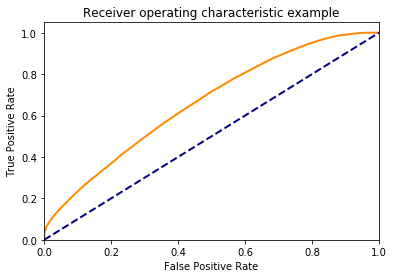

In [42]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

### AUC: Area Under the Curve

In [43]:
from sklearn.metrics import auc

In [44]:
auc(fpr,tpr)

0.66087961533328543

In [45]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
params = {'n_neighbors': [3,5,10]}
gscv = GridSearchCV(KNeighborsClassifier(),params)
gscv.fit(X_train, y_train)
gscv.best_params_

{'n_neighbors': 3}

In [47]:
y_pred = gscv.predict_proba(X_train)

fpr_knn, tpr_knn, _ = roc_curve(y_train, y_pred[:,1])
print(auc(fpr_knn,tpr_knn))

0.583993676087


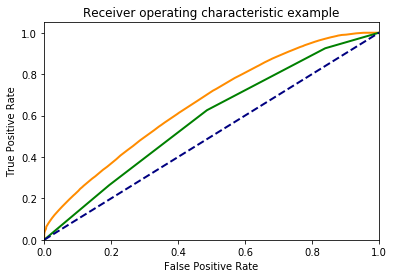

In [48]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw)
plt.plot(fpr_knn,tpr_knn, color='green',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

## Steps to finding a good model

- set aside test set

- use grid search and cross validation to generate metrics

- compare models on metrics (R^2, RMSE, Accuracy, AUC, ...)

- pick the best and evaluate on test set

### Review

- Accuracy
- Type 1 and 2 error
- Confusion Matrix
- Precision vs. Recall
- ROC Curve
- AUC